In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

## you can undo the lines below (but it will be fun for making fancy plots!)
# to make the lines below work, you have to download the file 'PostProcessingScripts' from https://github.com/FloorBroekgaarden/common_code
# and put this in the same directory as this one, and then only use the bottom line from this code below 
import sys

# from PostProcessingScripts import * 

# to make the screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))




## lets first take a quick look at the data

In [2]:
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different

path = '/Volumes/GROWL/Boesky24/alpha0_1beta0_25/'
file_name = 'COMPAS_Output_Weighted.h5'

full_path = path + file_name
fdata = h5.File(full_path, 'r')



In [3]:
print(fdata['BSE_System_Parameters'].keys())


<KeysViewHDF5 ['Add_Options_To_SysParms', 'Allow_Immediate_RLOF>CE_To_Survive_CE', 'Allow_MS_To_Survive_CE', 'Allow_Non_Stripped_ECSN', 'Allow_RLOF@Birth', 'Allow_Radiative_Envelope_To_Survive_CE', 'Allow_Touching@Birth', 'BB_Mass_xFer_Stblty_Prscrptn', 'BH_Kicks', 'CE_Alpha', 'CE_Alpha_Thermal', 'CE_Lambda', 'CE_Lambda_Multiplier', 'CE_Lambda_Prscrptn', 'CE_Mass_Accr_Constant', 'CE_Mass_Accr_Max', 'CE_Mass_Accr_Min', 'CE_Mass_Accr_Prscrptn', 'CE_Recomb_Enrgy_Dnsty', 'CE_Slope_Kruckow', 'CHE_Mode', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Check_Photon_Tiring_Limit', 'Circularise@MT', 'Conserve_AngMom@Circ', 'Cool_WindMassLoss_Multipl', 'Eccentricity', 'Eccentricity@ZAMS', 'Eccentricity_Dstrbtn', 'Eccentricity_Dstrbtn_Max', 'Eccentricity_Dstrbtn_Min', 'Eddington_Accr_Factor', 'Envelope_State_Prscrptn', 'Equilibrated_At_Birth', 'Error', 'Evolution_Mode', 'Fryer22_crit_COcore_Mass', 'Fryer22_mixing_fraction', 'Fryer_SN_Engine', 'Initial_Mass', 'Initial_Mass(1)', 'Initial_Mass(2)', 'Initial_Mass_Fun

In [4]:
print()
print("Keys in Run_Details:", list(fdata['Run_Details'].keys()))





Keys in Run_Details: ['Actual-Random-Seed', 'Actual-Random-Seed-Derivation', 'COMPAS-Version', 'COMPAS-Version-Derivation', 'Clock-Time', 'Clock-Time-Derivation', 'Objects-Created', 'Objects-Created-Derivation', 'Objects-Requested', 'Objects-Requested-Derivation', 'PISN-lower-limit', 'PISN-lower-limit-Derivation', 'PISN-upper-limit', 'PISN-upper-limit-Derivation', 'PPI-lower-limit', 'PPI-lower-limit-Derivation', 'PPI-upper-limit', 'PPI-upper-limit-Derivation', 'Run-End', 'Run-End-Derivation', 'Run-Start', 'Run-Start-Derivation', 'Wall-Time', 'Wall-Time-Derivation', 'actual-output-path', 'actual-output-path-Derivation', 'add-options-to-sysparms', 'add-options-to-sysparms-Derivation', 'allow-non-stripped-ECSN', 'allow-non-stripped-ECSN-Derivation', 'allow-rlof-at-birth', 'allow-rlof-at-birth-Derivation', 'allow-touching-at-birth', 'allow-touching-at-birth-Derivation', 'angular-momentum-conservation-during-circularisation', 'angular-momentum-conservation-during-circularisation-Derivation

In [5]:
print(fdata['Run_Details']['metallicity-min'][()][0])
metallicity_min = fdata['Run_Details']['metallicity-min'][()][0]


for param in ['semi-major-axis-max', 'semi-major-axis-min', 'minimum-secondary-mass', 'mass-ratio-min', 'mass-ratio-max',  'initial-mass-max', 'initial-mass-min']:
    param_val = fdata['Run_Details'][param][()][0]
    print(param, ' = ', param_val)
    


0.0001
semi-major-axis-max  =  1000.0
semi-major-axis-min  =  0.01
minimum-secondary-mass  =  0.1
mass-ratio-min  =  0.01
mass-ratio-max  =  1.0
initial-mass-max  =  150.0
initial-mass-min  =  5.0


## From hereon is really where we calculate the formation efficiency 

In [6]:
# This function below is copied from GROWL-catalog-public/CosmicIntegration/cosmic_integration/totalMassEvolvedPerZ.py

def analytical_star_forming_mass_per_binary_using_kroupa_imf(
        m1_min, m1_max, m2_min, fbin=1., imf_mass_bounds=[0.01,0.08,0.5,200]
):
    """
    Analytical computation of the mass of stars formed per binary star formed within the
    [m1 min, m1 max] and [m2 min, ..] rage,
    using the Kroupa IMF:

        p(M) \propto M^-0.3 for M between m1 and m2
        p(M) \propto M^-1.3 for M between m2 and m3;
        p(M) = alpha * M^-2.3 for M between m3 and m4;

    @Ilya Mandel's derivation
    """
    m1, m2, m3, m4 = imf_mass_bounds
    if m1_min < m3:
        raise ValueError(f"This analytical derivation requires IMF break m3  < m1_min ({m3} !< {m1_min})")
    alpha = (-(m4**(-1.3)-m3**(-1.3))/1.3 - (m3**(-0.3)-m2**(-0.3))/(m3*0.3) + (m2**0.7-m1**0.7)/(m2*m3*0.7))**(-1)
    # average mass of stars (average mass of all binaries is a factor of 1.5 larger)
    m_avg = alpha * (-(m4**(-0.3)-m3**(-0.3))/0.3 + (m3**0.7-m2**0.7)/(m3*0.7) + (m2**1.7-m1**1.7)/(m2*m3*1.7))
    # fraction of binaries that COMPAS simulates
    fint = -alpha / 1.3 * (m1_max ** (-1.3) - m1_min ** (-1.3)) + alpha * m2_min / 2.3 * (m1_max ** (-2.3) - m1_min ** (-2.3))
    # mass represented by each binary simulated by COMPAS
    m_rep = (1/fint) * m_avg * (1.5 + (1-fbin)/fbin)
    return m_rep



In [7]:
# COMPAS saves the distribution assumptions, fbin comes from https://arxiv.org/pdf/2405.01630 
# we dont have to correct for separation as this is already 
initial_mass_min = fdata['Run_Details']['initial-mass-min'][()][0]
initial_mass_max = fdata['Run_Details']['initial-mass-max'][()][0] 
minimum_secondary_mass = fdata['Run_Details']['minimum-secondary-mass'][()][0] 
f_binary = 1


m_rep_per_binary = analytical_star_forming_mass_per_binary_using_kroupa_imf(m1_min=initial_mass_min, m1_max=initial_mass_max,\
                                                                            m2_min=minimum_secondary_mass, fbin=f_binary)


print('1 binary in COMPAS represents', m_rep_per_binary, ' solar masses formed')

# now calculate the number of binaries in COMPAS simulation (over the entire simulation)
n_binaries = np.shape(fdata['BSE_System_Parameters']['SEED'][()])[0]
print(n_binaries)


total_mass_evolved_compas = n_binaries * m_rep_per_binary
print(total_mass_evolved_compas, ' [Msun]')


1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]


### now lets assign and plot the formation efficiencies:



In [8]:
print(fdata['BSE_Double_Compact_Objects'].keys())

<KeysViewHDF5 ['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'mixture_weight']>


In [9]:
Stellar_Type1 = fdata['BSE_Double_Compact_Objects']['Stellar_Type(1)'][()]
Stellar_Type2 = fdata['BSE_Double_Compact_Objects']['Stellar_Type(2)'][()]
Merges_Hubble_Time = fdata['BSE_Double_Compact_Objects']['Merges_Hubble_Time'][()]

BBH_mask = (Stellar_Type1==14) & (Stellar_Type2==14) & (Merges_Hubble_Time==True)
print('total DCOs in file = ', len(BBH_mask), 'total DCOs we mask = ', np.sum(BBH_mask)) # to check how many we are cutting :) 


mask_sys_BBHs = np.in1d(fdata['BSE_System_Parameters']['SEED'][()], fdata['BSE_Double_Compact_Objects']['SEED'][()][BBH_mask])
metallicity_BBHs = (fdata['BSE_System_Parameters']['Metallicity@ZAMS(1)'][()][mask_sys_BBHs])
print('with metallicities = ', metallicity_BBHs)

mixture_weight = fdata['BSE_Double_Compact_Objects']['mixture_weight'][()][BBH_mask]

formation_efficiencies = mixture_weight/total_mass_evolved_compas




total DCOs in file =  4881951 total DCOs we mask =  2521170
with metallicities =  [0.00103274 0.00062708 0.00113757 ... 0.00047619 0.00147745 0.00225284]


### plot the formation efficiency

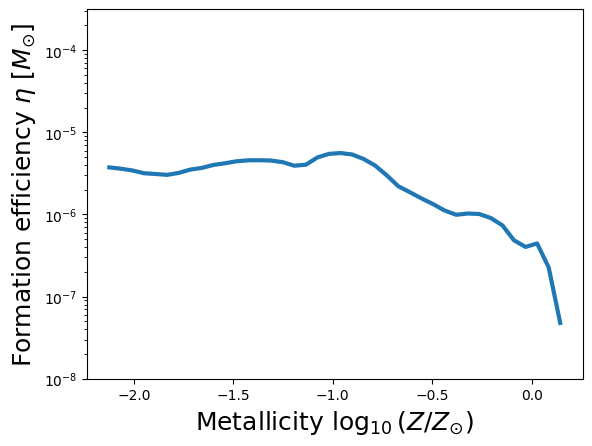

In [10]:
fs=18

hist, bin_edges = np.histogram(np.log10(metallicity_BBHs/0.0142), weights=formation_efficiencies, bins=40, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiencies)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
plt.ylim(10**-8, 10**-3.5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()

In [11]:
fdata.close()

This actually looks different (lower) compared to https://arxiv.org/pdf/2405.01623 (figure 3 orange line with circles). I think actually adam's plot might be slightly wrong (wrong normalization with the histogram bins. He probably didnt normalize for this